# Machine Learning Starter Kit - with FastAI

### Original Kaggle Competition

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

#### How much does a house cost?
![](http://www.hubbellhomes.com/images/community/368/tb/Pemberley-Hills-thumbNEW.jpg)

### Goal

It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

### Metric

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

### Dataset size

- **Train**: 1460
- **Test**: 1458

## 1. Load Libraries

In [1]:
%matplotlib inline
import sys

# or wherever you have saved the repo
sys.path.append('/Users/tlee010/Desktop/github_repos/fastai/')

# importing fastai
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import numpy as np

#### 1.1 Load the test and train data

In [2]:
df_raw = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_raw['SalePrice'] = np.log(df_raw['SalePrice'])

In [3]:
print(df_raw.shape, df_test.shape)

(1460, 81) (1459, 80)


#### 1.2 Evaluation Metric

In [4]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

## 2. Features

### 2.1 Review Categorical Features

From the data itself, many of these features are stored as words. These will be considered as categorical variables. From the data dictionary we see that some of the numerical variables are actually encodings for categorical variables as well. An example is `MSSubClass` are integer encodings to represent index. 

In [5]:
df_raw.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### 2.2 Review of Numerical Features

From reviewing the data, we see that a number of the fields have `"area"` or `"SF"` in the name indicating an area or continuous variable. We will also be considering `overallqual` as a continuous variable.

In [6]:
numeric_cols = [x for x in df_raw.columns if ('Area' in x) | ('SF' in x)] + ['SalePrice','LotFrontage','MiscVal','EnclosedPorch','3SsnPorch','ScreenPorch','OverallQual','OverallCond','YearBuilt']
numeric_cols

['LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'PoolArea',
 'SalePrice',
 'LotFrontage',
 'MiscVal',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'OverallQual',
 'OverallCond',
 'YearBuilt']

#### Use fastai's train_cats to auto-detect categories

In [7]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): 
            df[n] = c.astype('category')
train_cats(df_raw)

#### Hardcode some Categorical Columns, numbers that represent categories

In [8]:
df_raw['MSSubClass'] = df_raw['MSSubClass'].astype('category')
df_raw['YearBuilt'] = df_raw['YearBuilt'].astype('category')
df_raw['GarageYrBlt'] = df_raw['GarageYrBlt'].astype('category')
df_raw.loc[df_raw['MasVnrArea'].isna(),'MasVnrArea'] = 0
df_raw.loc[df_raw['LotFrontage'].isna(),'LotFrontage'] = 0

In [9]:
#df_raw.info()

### 3. Start a Basic Random Forest Model

#### 3.1 Asside - prepping dataframe for random forests. 

- We want to change fields to either one hot encoding or label encoding. 
- FastAI proc_df will assist in this

```
proc_df(df, y_fld, skip_flds=None, do_scale=False, na_dict=None, preproc_fn=None, max_n_cat=None, subset=None)
```

proc_df takes a data frame df and splits off the response variable, and
changes the df into an entirely numeric dataframe.

#### Parameters:
**`df`**: The data frame you wish to process.

**`y_fld`**: The name of the response variable

**`skip_flds`**: A list of fields that dropped from df.
**`do_scale`**: Standardizes each column in df.

**`na_dict`**: a dictionary of na columns to add. Na columns are also added if there
    are any missing values.

**`preproc_fn`**: A function that gets applied to df.
**`max_n_cat`**: The maximum number of categories to break into dummy values, instead
    of integer codes.

subset: Takes a random subset of size subset from df.

#### Returns:
**`[x, y, nas]`**:
    **`x`**: x is the transformed version of df. x will not have the response variable
        and is entirely numeric.

    **`y`**: y is the response variable

    nas: returns a dictionary of which nas it created, and the associated median.



#### 3.1b Compare before and after Encoding

In [10]:
df_raw.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694


In [11]:
def split_vals(a,n): return a[:n], a[n:]
df_trn,y_trn, _ = proc_df(df_raw,'SalePrice')
n_valid = 170
n_trn = len(y_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

raw_train, raw_valid = split_vals(df_raw, n_trn)


In [12]:
df_trn.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,6,4,65.0,8450,2,0,4,4,1,...,0,0,0,0,0,0,2,2008,9,5


### 3.2 Random Forest Model

We want to be mindful that the total training set size is 1460, so the number of trees should be less than that number.

In [13]:
set_rf_samples(400)

In [14]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=100)

In [15]:
m.fit(df_trn,y_trn)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [16]:
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [17]:
print_score(m)

[0.11006476316521728, 0.13141172086246, 0.92417518715897906, 0.88995858558267549]


In [18]:
y_hat = m.predict(df_trn)

In [19]:
rmse(y_trn,y_hat)

0.11275844609345498

## 4. Improvement - try to swap areas to log as well

In [20]:
Area_cols = [x for x in numeric_cols if ('SF' in x) | ('Area' in x)] 

In [21]:
for col in Area_cols:
    df_trn[col] = np.log(df_trn[col]+1) 

In [22]:
m.fit(df_trn,y_trn)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [23]:
y_hat = m.predict(df_trn)

In [24]:
rmse(y_trn,y_hat)

0.11190397185703857

### Error Comparison

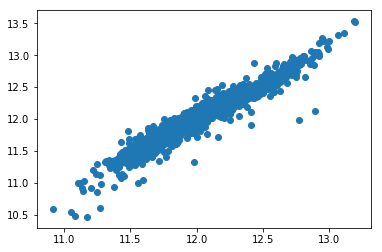

In [25]:
plt.scatter(y_hat,y_trn)

##  5. Model Interpretation 

### Confidence based on tree variance

Random forest is a collection of trees. So what we will do is:

```python
Tree_1 -> Predict_1
Tree_2 -> Predict_2
Tree.. -> Predict_..
Tree_N -> Predict_N
```

Then from all those datasets we can get a standard deviation of the predictions


In [26]:
m.estimators_[:3]

[DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1813778238, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1339592546, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1683387099, splitter='best')]

#### For each tree we want to predict , so normally would loop through each one...
```python
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
```

#### But to run in parallel, we will use the following function
```python
parallel_trees(m, fn, njobs=8)

m = model
fn = function
njobs = threads

Will run all the trees
```

In [27]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 110 ms, sys: 74.5 ms, total: 185 ms
Wall time: 175 ms


(12.12965782737562, 0.24904393310848466)

### For example, look at MSSubClass as a field

In [28]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
flds = ['MSSubClass', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('MSSubClass', as_index=False).mean()
enc_summ

,MSSubClass,SalePrice,pred,pred_std
0,20,12.106413,12.373395,0.281162
1,30,11.314765,11.869035,0.321855
2,40,NaN,NaN,NaN
3,45,NaN,NaN,NaN
4,50,11.859958,12.065323,0.282621
5,60,12.293895,12.637130,0.322340
6,70,11.969094,12.215204,0.306214
7,75,NaN,NaN,NaN
8,80,12.085210,12.228139,0.255207
9,85,11.761871,12.088182,0.247547


In [29]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]

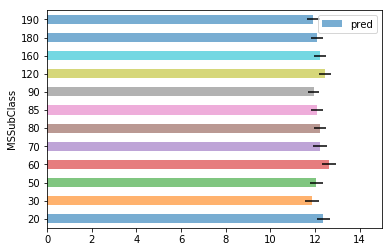

In [30]:
enc_summ.plot('MSSubClass', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,15));

### For example, look at TotRmsAbvGrd as a field


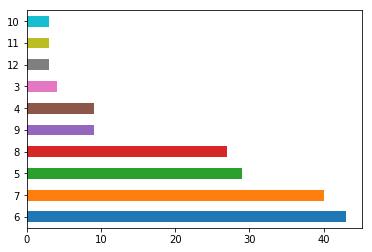

In [31]:
raw_valid.TotRmsAbvGrd.value_counts().plot.barh();

In [32]:
flds = ['TotRmsAbvGrd', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ


,SalePrice,pred,pred_std
TotRmsAbvGrd,,,
3,11.670066,12.081798,0.261565
4,11.577034,12.043835,0.300773
5,11.746023,12.107282,0.275068
6,11.911988,12.200513,0.275404
7,12.196997,12.461050,0.293617
8,12.192737,12.462075,0.301496
9,12.459674,12.648534,0.314719
10,12.393713,12.731129,0.306210
11,11.820380,11.947220,0.276365


### Feature importance

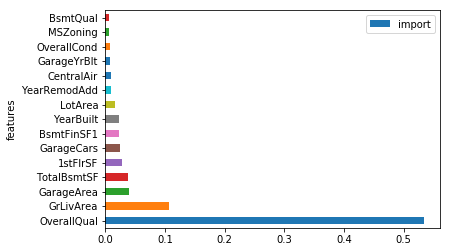

In [33]:
feat_imp_df = pd.DataFrame({
    'features': df_trn.columns,
    'import' : m.feature_importances_
})

feat_imp_df.sort_values(by='import', ascending=False).head(15).plot.barh(x='features', y='import')

In [34]:
fi = rf_feat_importance(m, X_train); fi[:10]


,cols,imp
17,OverallQual,0.533953
46,GrLivArea,0.106130
62,GarageArea,0.039222
38,TotalBsmtSF,0.038608
43,1stFlrSF,0.027634
61,GarageCars,0.025136
34,BsmtFinSF1,0.023395
19,YearBuilt,0.023180
4,LotArea,0.016114
20,YearRemodAdd,0.010155


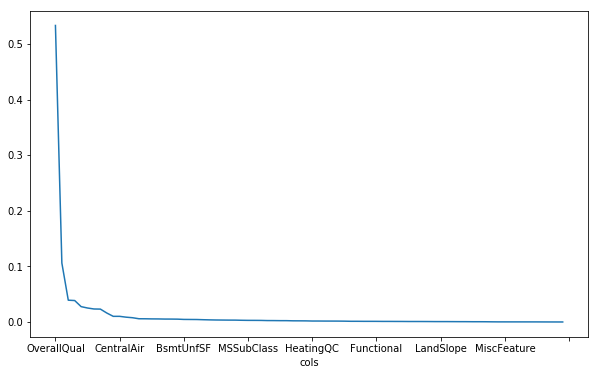

In [35]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [36]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)


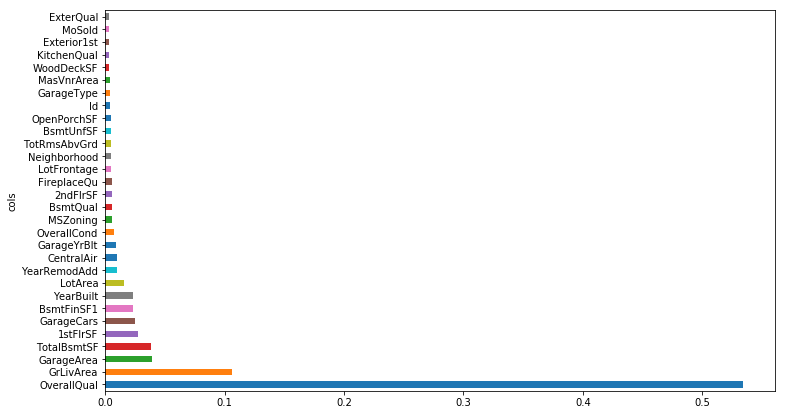

In [37]:
plot_fi(fi[:30]);

#### Keep only the most important features

In [38]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

20

In [39]:
df_keep = X_train[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

## Removing Redundant Features

In [40]:
from scipy.cluster import hierarchy as hc

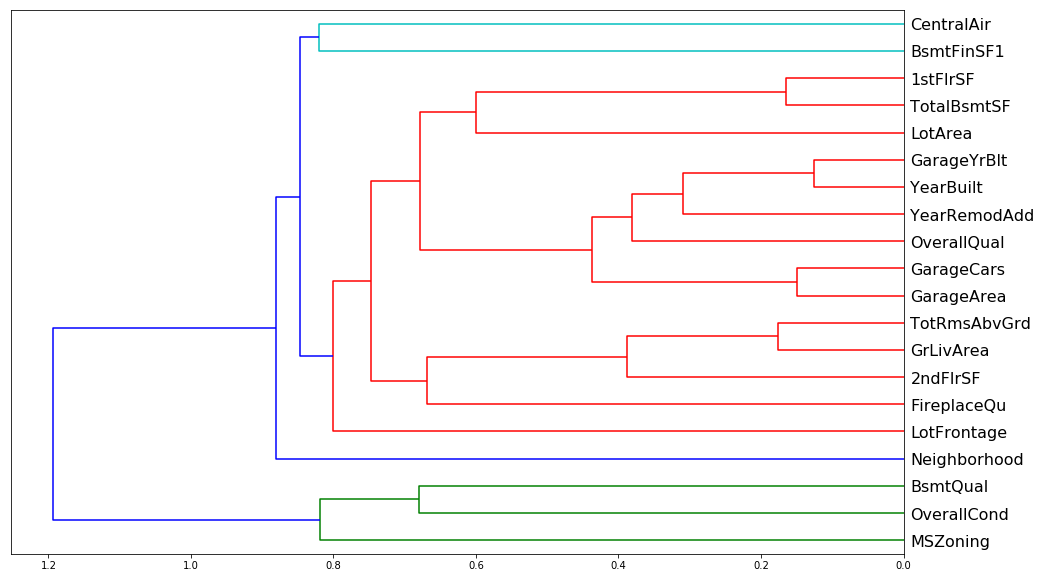

In [41]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [42]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [43]:
get_oob(df_keep)

0.86497889615469403

In [44]:
for c in ('TotalBsmtSF','1stFlrSF', 'YearBuilt','GarageYrBlt', 'GarageArea','GarageCars'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

TotalBsmtSF 0.860439850454
1stFlrSF 0.863194536527
YearBuilt 0.86050678621
GarageYrBlt 0.864033901118
GarageArea 0.864879112229
GarageCars 0.863691512672


In [45]:
to_drop = ['1stFlrSF','GarageYrBlt','GarageCars']
get_oob(df_keep.drop(to_drop, axis=1))

0.86421260355000407

## Partial Dependence

In [46]:
from pdpbox import pdp
from plotnine import *


In [47]:
set_rf_samples(400)


In [48]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

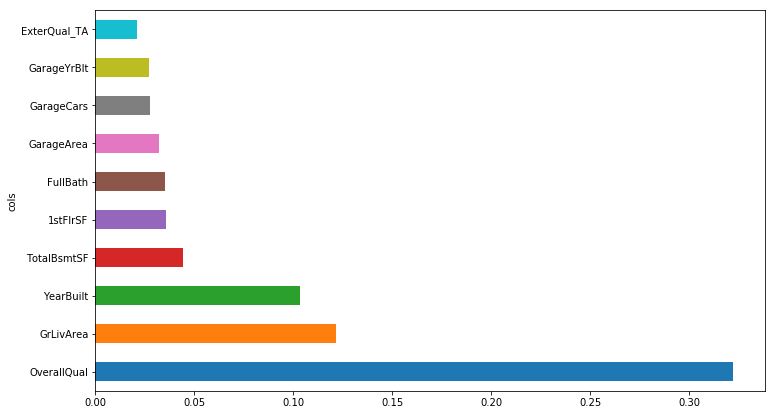

In [49]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);


In [50]:
x_all = get_sample(df_raw, 500)

In [51]:
x_all['YearBuilt'] = x_all['YearBuilt'].astype(int)

In [52]:
#!pip install scikit-misc

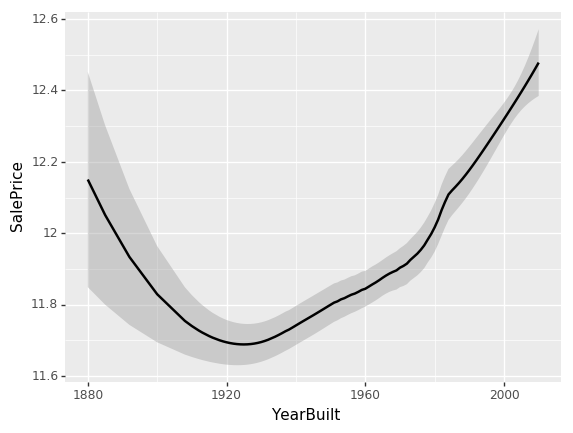

<ggplot: (7540104119)>

In [53]:
ggplot(x_all, aes('YearBuilt', 'SalePrice'))+stat_smooth(se=True, method='loess')


In [54]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

In [55]:
#plot_pdp('YearBuilt')


## Tree Interpreter

In [102]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

In [103]:
from treeinterpreter import treeinterpreter as ti

In [104]:
row = X_valid.values[None,0]; row

array([[  1291.,      9.,      4.,      0.,  14112.,      2.,      0.,      1.,      4.,      1.,      1.,
             1.,     13.,      3.,      3.,      1.,      8.,      5.,      7.,     66.,   1964.,      4.,
             2.,     14.,      7.,      2.,     86.,      4.,      5.,      3.,      4.,      4.,      1.,
             3.,   1014.,      6.,      0.,    138.,   1152.,      2.,      5.,      2.,      5.,   1152.,
             0.,      0.,   1152.,      1.,      0.,      1.,      0.,      3.,      1.,      4.,      6.,
             7.,      1.,      3.,      2.,     51.,      2.,      2.,    484.,      5.,      5.,      3.,
           227.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,      4.,
          2010.,      9.,      5.]])

In [105]:
prediction, bias, contributions = ti.predict(m, row)

In [106]:
prediction[0], bias[0]

(11.896173389272473, 12.018035189627224)

In [112]:
idxs = np.argsort(contributions[0])

In [113]:
[o for o in zip(df_raw.columns[idxs], X_valid.iloc[0][idxs], contributions[0][idxs])]


[('OverallQual', 5.0, -0.16083618578662406),
 ('GrLivArea', 1152.0, -0.086318466797528304),
 ('YearRemodAdd', 1964.0, -0.01462637374060316),
 ('ExterQual', 4.0, -0.014527990026928218),
 ('FullBath', 1.0, -0.012818379344028186),
 ('KitchenQual', 4.0, -0.0059600175281123938),
 ('MoSold', 4.0, -0.0048605763370763722),
 ('Exterior1st', 14.0, -0.0045836668188955262),
 ('MSSubClass', 9.0, -0.004453367661809926),
 ('YearBuilt', 66.0, -0.003977477974645538),
 ('OpenPorchSF', 0.0, -0.0036053258801779899),
 ('MasVnrArea', 86.0, -0.0027103322365045202),
 ('YrSold', 2010.0, -0.0026951514341223338),
 ('LotFrontage', 0.0, -0.0024698652692001222),
 ('HouseStyle', 8.0, -0.00231795540808597),
 ('2ndFlrSF', 0.0, -0.0021390995315432536),
 ('HeatingQC', 5.0, -0.0011178386489683946),
 ('Neighborhood', 13.0, -0.00097207659256537404),
 ('BsmtFinSF2', 0.0, -0.0003844300802155587),
 ('RoofStyle', 4.0, -0.00029164564685375539),
 ('BsmtQual', 4.0, -0.00015172874688063054),
 ('BsmtFinType2', 6.0, 0.0),
 ('Electri